In [1]:
%load_ext autoreload
%autoreload 2

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install -e "../reinvent_scoring"

Obtaining file:///home/springnuance/reinvent-hitl/reinvent_scoring
  Preparing metadata (setup.py) ... done
  Attempting uninstall: reinvent-scoring
    Found existing installation: reinvent-scoring 0.0.73
    Uninstalling reinvent-scoring-0.0.73:
      Successfully uninstalled reinvent-scoring-0.0.73
  Running setup.py develop for reinvent-scoring


In [3]:
import os
from multiprocessing import Pool
import pandas as pd
import pickle

from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, recall_score, precision_score,f1_score

from write import write_config_file,\
                  write_query_to_csv,\
                  write_runs_sh, write_idx,\
                  write_training_data,\
                  write_sample_file,\
                  write_run_sample
from acquisition import select_query
from models import Tanimoto_model
from query import query


from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import gpflow
from gpflow.utilities import positive
from gpflow.utilities.ops import broadcasting_elementwise
from gpflow.mean_functions import Constant
import tensorflow as tf
import reinvent_scoring


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rel

# configuration

In [4]:
experiment = 5 # options: numbers 1-5 that define which seed is used in user demo

seeds = [1718, 1896, 3975, 8355, 9774] 
seed = seeds[experiment-1]
np.random.seed(seed)
tf.random.set_seed(seed)

acquisition='thompson' #options: 'thompson', 'uncertainty', 'random', 'greedy'
READ_ONLY = False # Use 'True' to playback an existing experiment (reads queries and feedback from files instead of using the algorithm)
usecase = 'drd2'
simulated_human = True
verbose = True # print out details during interaction
loop, last_job=0, None # Do not change

In [5]:
# load dependencies
import os
import re
import json
import tempfile

# --------- change these path variables as required

print("The current working directory is", os.getcwd())
print(os.path.exists("../Reinvent"))
print(os.path.exists("../../miniconda3/envs/cc_env_reinvent"))

# --------- change these path variables as required

reinvent_dir = os.path.expanduser("../Reinvent")
reinvent_env = os.path.expanduser("../../../miniconda3/envs/cc_env_reinvent")


The current working directory is /home/springnuance/reinvent-hitl/Chemists-Component-Binh
True
True


In [6]:
from load_data import load_config

def train_GaussianProcess(X_updated, y_updated, jobid, acquisition, seed, loop, iteration):
    jobid, jobname, N0, n_restarts, n_batch, _, fpdim, step,\
    output_dir, _ = load_config(acquisition,seed,loop, jobid)
    
    start=time.time()
    
    gpc = Tanimoto_model(X_updated, y_updated)
    model_dir = output_dir+"/models/model_{}".format(iteration)
    if (iteration % step) == 0:
        gpc.predict_y_compiled = tf.function(gpc.predict_f, input_signature=[tf.TensorSpec(shape=[None, fpdim], dtype=tf.float64)])
    tf.saved_model.save(gpc, model_dir)
    print('save model at path {}'.format(model_dir))
    conf_filename = write_config_file(jobid, jobname, 
                                      reinvent_dir, reinvent_env, output_dir, fpdim, loop, iteration, model_dir, seed)
    write_sample_file(jobid, jobname, output_dir, loop, iteration)
    print('training model at iteration {} use {} s'.format(iteration, time.time()-start))
    return gpc

In [7]:
def get_labels(p):
    label = p.copy()
    label[label > 0.5] = 1
    label[label < 0.5] = 0
    label[label == 0.5] = np.random.binomial(1, 0.5, sum(label==0.5))
    return label.astype(int)

def evaluate(model, X, Y, accuracy,recall, precision, f1, MCC, Kappa, rmse):
    mean, var = model.predict_f(X)
    rmse += [np.sqrt(np.mean((mean-Y)**2))]
    pred = get_labels(mean.numpy())
    Y = get_labels(Y)
    recall += [recall_score(Y,pred)]
    accuracy += [accuracy_score(Y, pred)]
    precision += [precision_score(Y,pred)]
    f1 += [f1_score(Y,pred)]
    MCC += [matthews_corrcoef(Y, pred)]
    Kappa += [cohen_kappa_score(Y, pred)]
    return accuracy, recall, precision, f1, MCC, Kappa, rmse

# HITL

In [8]:
from load_data import load_config

# load configuration 
jobid, jobname, N0, n_restarts,\
n_batch, n_iteration, fpdim, step,\
output_dir, lastloop_dir =\
        load_config(acquisition,seed, loop, last_job)

print("Finish loading running config\n")

print("jobid: ", jobid)
print("jobname: ", jobname)
print("N0: ", N0)
print("n_restarts: ", n_restarts)
print("n_batch: ", n_batch)
print("n_iteration: ", n_iteration)
print("fpdim: ", fpdim)
print("step: ", step)
print("output_dir: ", output_dir)
print("lastloop_dir: ", lastloop_dir)

Finish loading running config

jobid:  22-05-2024
jobname:  Task2_demo_thompson
N0:  10
n_restarts:  2
n_batch:  10
n_iteration:  10
fpdim:  1024
step:  1
output_dir:  /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0
lastloop_dir:  None


In [9]:
from load_data import load_data_config

# load training data configuration
train_num, test_num, train_data_path, test_data_path, y_field =\
        load_data_config(usecase, lastloop_dir)
print("\nFinish loading training data config\n")

print("train_num: ", train_num)
print("test_num: ", test_num)
print("train_data_path: ", train_data_path)
print("test_data_path: ", test_data_path)
print("y_field: ", y_field)


Finish loading training data config

train_num:  10000
test_num:  2000
train_data_path:  data/drd2_regression.train.csv
test_data_path:  data/drd2_regression.test.csv
y_field:  activity


In [10]:
print(y_field)

activity


In [11]:
from load_data import load_data

# load data
X_train, X_test, y_train, y_test,\
smiles_train, id_train,\
X_L, X_U, y_L, y_U, L , U =\
        load_data(train_data_path, test_data_path, output_dir, 
                  train_num, N0, y_field, id_field=None, ext='csv', 
                  sampling=True, normalization=False)

print("\nFinish loading data\n")

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
print("smiles_train shape: ", len(smiles_train))
print("id_train shape: ", len(id_train))
print("X_L shape: ", X_L.shape)
print("X_U shape: ", X_U.shape)
print("y_L shape: ", y_L.shape)
print("y_U shape: ", y_U.shape)
print("L shape: ", L.shape)
print("U shape: ", U.shape)

data/drd2_regression.train.csv
sampling


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

transformation spend 12.175585746765137 s

Finish loading data

X_train shape:  (10000, 1024)
X_test shape:  (68944, 1024)
y_train shape:  (10000, 1)
y_test shape:  (68944, 1)
smiles_train shape:  10000
id_train shape:  10000
X_L shape:  (10, 1024)
X_U shape:  (9990, 1024)
y_L shape:  (10, 1)
y_U shape:  (9990, 1)
L shape:  (10,)
U shape:  (9990,)


In [12]:
X_updated = X_L
y_updated = y_L

# Fit model with D_0

start = time.time()

gpc = train_GaussianProcess(X_updated, y_updated, jobid, acquisition,seed, loop, 0)

print("training spend {} s".format(time.time() - start))

# Evaluate performance in test data
accuracy, recall, precision, f1, MCC , Kappa, rmse = [] ,[], [], [], [], [], []
start=time.time()

accuracy, recall, precision, f1, MCC , Kappa, rmse = evaluate(gpc, X_test, y_test, accuracy, recall, precision, f1, MCC, Kappa, rmse)

print("evaluation spend {} s".format(time.time()-start))

if verbose:
    print('accuracy is {}'.format(accuracy))
    print('recall is {}'.format(recall))
    print('MCC is {}'.format(MCC))
    print('Kappa is {}'.format(Kappa))
    print('rmse is {}'.format(rmse))

# Baseline prediction: mean of training data
pred_baseline = np.repeat(1, len(y_test))
label_test = get_labels(y_test)
accuracy_baseline = accuracy_score(label_test, pred_baseline)
recall_baseline = recall_score(label_test, pred_baseline)
MCC_baseline = matthews_corrcoef(label_test, pred_baseline)
Kappa_baseline = cohen_kappa_score(label_test, pred_baseline)

if verbose: 
    print("Baseline accuracy: {}".format(accuracy_baseline))

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_0/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_0/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_0
training model at iteration 0 use 4.709865093231201 s
training spend 4.710599899291992 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


evaluation spend 1.7295255661010742 s
accuracy is [0.9839870039452309]
recall is [0.0]
MCC is [0.0]
Kappa is [0.0]
rmse is [0.12208898604278072]
Baseline accuracy: 0.016012996054769087


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


In [13]:
print("Start iteration")

positive_molecules_num = np.array([np.sum(y_updated)], dtype=np.int)
idx_query = np.array([], dtype='i')
all_smiles_query = []
D0_smiles = smiles_train[L]

for iteration in np.arange(1,n_iteration+1):
    # CREATE QUERY
    print(f'iteration {iteration}')
    queryfile_identifier = 'query_it{}'.format(iteration) 
    if not READ_ONLY:
        # Elicit n_batch feedback
        t = iteration
        i_query = select_query(U, X_train, n_batch, gpc, acquisition, X_updated, y_updated, L, t)
    elif READ_ONLY:
        query_csv = pd.read_csv(output_dir + '/query/{}.csv'.format(queryfile_identifier))
        sq = query_csv['SMILES']
        i_query = np.array([list(smiles_train).index(s) for s in sq])

    idx_query = np.append(idx_query,i_query)
    U = np.setdiff1d(U,i_query)
    if verbose:
        print("Feedback on n={}".format(i_query))
        print("Size of pool: {}".format(len(U)))

    query_smiles = smiles_train[i_query]
    all_smiles_query += [query_smiles]

    # Write the query to a csv file
    if not READ_ONLY:
        write_query_to_csv(query_smiles, id_train, i_query, output_dir + '/query/{}.csv'.format(queryfile_identifier), output_dir)

    if not simulated_human:
        input("Press Enter to continue...")
    # READ RESPONSE QUERY
    print("Read response at iteration {}".format(iteration))
    # Response
    if simulated_human:
        y_response = y_train[i_query]
        unkown_idx=np.where(y_response==-1)[0] 
        if(len(unkown_idx)>0): # If simulated feedback not pre-computed
              y_response[unkown_idx]=query(query_smiles[unkown_idx])
              #update y_train
              y_train[i_query[unkown_idx]] = y_response[unkown_idx]
    else:
        y_csv = pd.read_csv(output_dir + '/query/{}_with_ratings.csv'.format(queryfile_identifier)) 
        smiles_response = list(y_csv['SMILES'])
        responses = y_csv['rating'] 
        order = [smiles_response.index(smiles_train[i]) for i in i_query]
        y_response = np.array([responses[i] for i in order], dtype=float) # match responses using smiles
        y_response=y_response.reshape(len(y_response),1)
        # filter out molecules without feedback (rating=0)
        got_feedback = y_response != 0
        y_response = y_response[got_feedback]
        i_query = i_query[np.squeeze(got_feedback)]
        # parse numerical feedback from columns 1=0, 5=1 and the rest in between
        y_response = (y_response - 1)/4.0
        y_response=y_response.reshape(len(y_response),1)
        if verbose:
            print("response is")
            print(y_response)

    # Fit a new model, evaluate performance in test data
    X_updated = np.vstack((X_updated, X_train[i_query,:]))
    y_updated = np.concatenate((y_updated, y_response))
    gpc=train_GaussianProcess(X_updated, y_updated,jobid, acquisition,seed,loop, iteration)
    positive_molecules_num=np.append(positive_molecules_num,np.sum(y_updated))
    accuracy, recall, precision, f1, MCC , Kappa, rmse = evaluate(gpc, X_test, y_test, accuracy, recall, precision, f1, MCC, Kappa, rmse)

    if verbose:
        print(accuracy[iteration])
        print(precision[iteration])
        print(f1[iteration])
        print(recall[iteration])
        print(MCC[iteration])
        print(Kappa[iteration])
        print(rmse[iteration])

dat_save = {
    'hitl params': {'N0': N0, 'T': iteration, 'n_batch': n_batch, 'step': step, 'acquisition': acquisition},
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'MCC': MCC,
    'Kappa': Kappa,
    'rmse': rmse,
    'baseline accuracy': accuracy_baseline,
    'baseline_recall': recall_baseline,
    'baseline_MCC': MCC_baseline,
    'baseline_Kappa': Kappa_baseline,
    'idx_query': idx_query,
    'smiles_D0': D0_smiles,
    'smiles_query': all_smiles_query,
    'positive_molecules_num': positive_molecules_num
}

filename = output_dir + '/log_{}_it{}.p'.format(acquisition,iteration)
with open(filename , 'wb') as f:
    pickle.dump(dat_save, f)

if verbose:
    print('accuracy is {}'.format(accuracy))
    print('recall is {}'.format(recall))
    print('MCC is {}'.format(MCC))
    print('Kappa is {}'.format(Kappa))
    print('rmse is {}'.format(rmse))

# Create shell scripts for evaluating performance of Chemist's component as Reinvent scoring function: 
# Script for reinforcement learning training of agent at each iteration
write_runs_sh(seed, output_dir, reinvent_env, reinvent_dir, step, n_iteration)
# Script for sampling molecules to evaluate the quality of Reinvent output once the agents are trained
write_run_sample(seed, output_dir, reinvent_env, reinvent_dir, step, n_iteration)

Start iteration
iteration 1
Feedback on n=[6926 4975 3067 1842 4154 7165 7957 4821 7409 7454]
Size of pool: 9980
Read response at iteration 1


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_1/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_1/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_1
training model at iteration 1 use 6.51638126373291 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9839870039452309
0.0
0.0
0.0
0.0
0.0
0.11616046348167658
iteration 2
Feedback on n=[8979 5198 5521 9732 4587 9934 8860 2543 3059 2495]
Size of pool: 9970
Read response at iteration 2


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_2/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_2/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_2
training model at iteration 2 use 2.6670613288879395 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9839870039452309
0.0
0.0
0.0
0.0
0.0
0.11274844584357341
iteration 3
Feedback on n=[1949 1062 2197 3246 1222  426 3351 7851 3806 7052]
Size of pool: 9960
Read response at iteration 3


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_3/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_3/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_3
training model at iteration 3 use 2.427116632461548 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9840015084706428
1.0
0.0018099547511312218
0.0009057971014492754
0.029854740059171162
0.0017810235718890288
0.10326560964140062
iteration 4
Feedback on n=[9592 5964 4187 5251 5227  154 3820 7443 6433 4265]
Size of pool: 9950
Read response at iteration 4


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_4/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_4/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_4
training model at iteration 4 use 2.043497323989868 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9840885356231144
1.0
0.012601260126012601
0.006340579710144928
0.07899165498708981
0.012401978717318629
0.09723643381525834
iteration 5
Feedback on n=[9833 8086 8424 5720 7677 2291 1235 4685 2606 8879]
Size of pool: 9940
Read response at iteration 5


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_5/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_5/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_5
training model at iteration 5 use 32.652501344680786 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9841030401485263
1.0
0.014388489208633093
0.007246376811594203
0.08444624374102182
0.014161349202505669
0.09730566508182108
iteration 6
Feedback on n=[6749 7192 9407 2881 7428 6463 7348 1964 2142 4628]
Size of pool: 9930
Read response at iteration 6


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_6/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_6/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_6
training model at iteration 6 use 1.0626707077026367 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9842770944534694
1.0
0.03558718861209964
0.018115942028985508
0.133532857872509
0.03503729736831884
0.091802704179923
iteration 7
Feedback on n=[9813  733 9048 6022 2651 1031  486 8244 6858 2745]
Size of pool: 9920
Read response at iteration 7


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_7/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_7/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_7
training model at iteration 7 use 1.5734457969665527 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9860321420283128
0.9548387096774194
0.2351072279586974
0.13405797101449277
0.35502615380088054
0.2320794442117824
0.09280037312661722
iteration 8
Feedback on n=[2280 9005 9318  100 8124 3177 7374 4158  769 7270]
Size of pool: 9910
Read response at iteration 8


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_8/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_8/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_8
training model at iteration 8 use 1.7240192890167236 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.9864672777906707
0.9621621621621622
0.27618308766485644
0.161231884057971
0.39097565835996645
0.27284074525785207
0.09051647066453399
iteration 9
Feedback on n=[8479 8604 4069  504 8997 9414 6346 8791 7745 2685]
Size of pool: 9900
Read response at iteration 9


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_9/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_9/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_9
training model at iteration 9 use 1.4061393737792969 s


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


0.987424576467858
0.8963210702341137
0.3820384889522451
0.2427536231884058
0.4628442205309929
0.37779178633854427
0.0901353089639152
iteration 10
Feedback on n=[4181 2682 1755 9222 2500 5828 9474 7091 4374 4245]
Size of pool: 9890
Read response at iteration 10


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_10/assets


INFO:tensorflow:Assets written to: /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_10/assets


save model at path /home/springnuance/reinvent-hitl/Chemists-Component-Binh/results/Task2_demo_thompson_22-05-2024_seed_9774/loop_0/models/model_10
training model at iteration 10 use 1.2114324569702148 s
0.9879032258064516
0.9017857142857143
0.4208333333333333
0.27445652173913043
0.4938255764296977
0.4164727911834393
0.08777897787759355
accuracy is [0.9839870039452309, 0.9839870039452309, 0.9839870039452309, 0.9840015084706428, 0.9840885356231144, 0.9841030401485263, 0.9842770944534694, 0.9860321420283128, 0.9864672777906707, 0.987424576467858, 0.9879032258064516]
recall is [0.0, 0.0, 0.0, 0.0009057971014492754, 0.006340579710144928, 0.007246376811594203, 0.018115942028985508, 0.13405797101449277, 0.161231884057971, 0.2427536231884058, 0.27445652173913043]
MCC is [0.0, 0.0, 0.0, 0.029854740059171162, 0.07899165498708981, 0.08444624374102182, 0.133532857872509, 0.35502615380088054, 0.39097565835996645, 0.4628442205309929, 0.4938255764296977]
Kappa is [0.0, 0.0, 0.0, 0.001781023571889028

/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/sklearn/metrics/classification.py:564: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_mat = np.ones([n_classes, n_classes], dtype=np.int)


Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

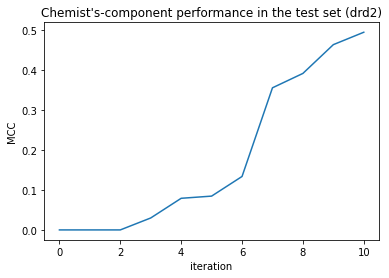

In [14]:
# Visualize performance of Chemist's component as predictive model in the test data
plt.plot(MCC)
plt.xlabel('iteration')
plt.ylabel('MCC')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

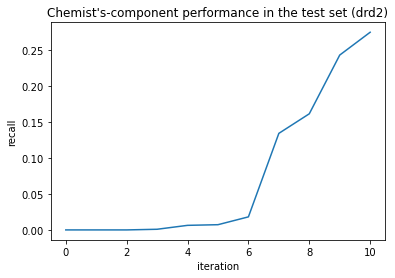

In [16]:
plt.plot(recall)
plt.xlabel('iteration')
plt.ylabel('recall')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

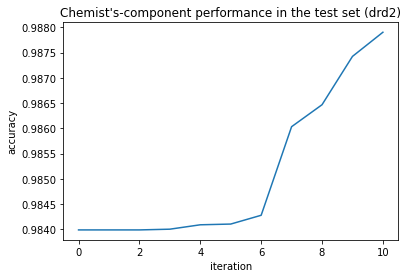

In [17]:
plt.plot(accuracy)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title("Chemist's-component performance in the test set (drd2)")

Text(0.5, 1.0, "Chemist's-component performance in the test set (drd2)")

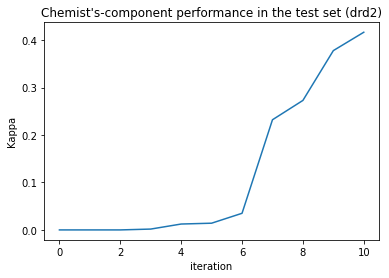

In [18]:
plt.plot(Kappa)
plt.xlabel('iteration')
plt.ylabel('Kappa')
plt.title("Chemist's-component performance in the test set (drd2)")